<h1 style='color:Green' align='center'>Celebrity Image Classification<h1>


In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h2>Preprocessing :- Detect face and eyes</h2>


In [2]:
img = cv2.imread('./test_images/linus1.jpg')
img.shape

(225, 225, 3)

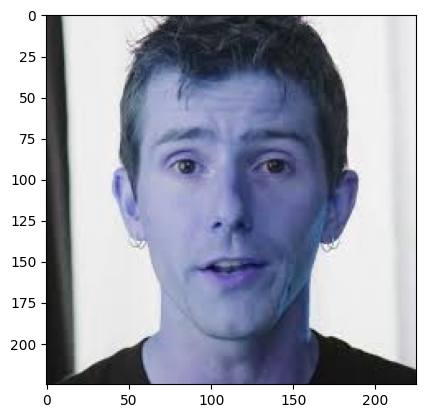

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(225, 225)

In [5]:
gray #representation in terms of matrix

array([[ 49,  48,  47, ..., 238, 238, 238],
       [ 49,  48,  47, ..., 238, 238, 238],
       [ 49,  48,  47, ..., 238, 238, 238],
       ...,
       [ 24,  23,  20, ...,  25,  25,  23],
       [ 24,  23,  20, ...,  24,  24,  22],
       [ 19,  22,  23, ...,  24,  23,  25]], dtype=uint8)

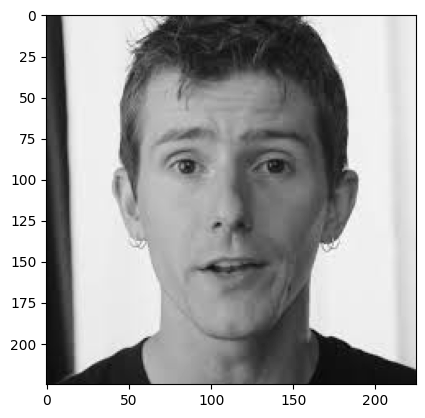

In [6]:
plt.imshow(gray, cmap='gray')

Using HaarCascade(Refer to OpenCV Documentation)


In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 39,  32, 149, 149]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(39), np.int32(32), np.int32(149), np.int32(149))

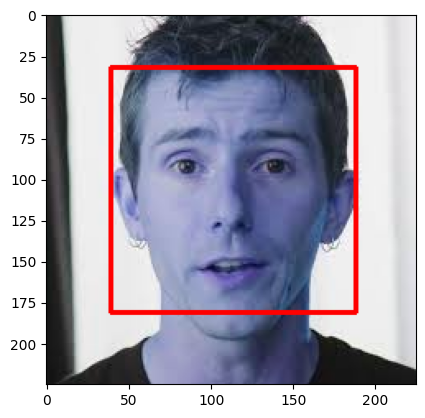

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

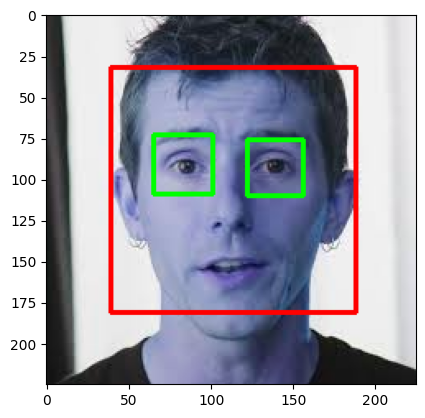

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Crop The Face


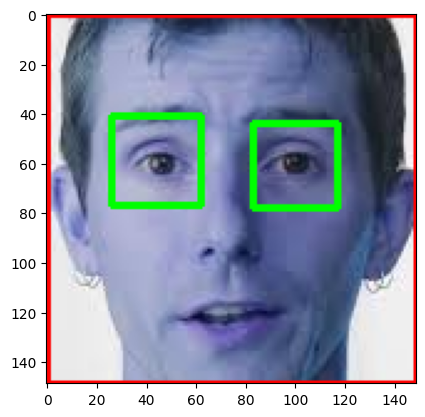

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(149, 149, 3)

Preprocessing: Use wavelet transform as a feature for traning our model


Wavelet Transformation (Help model distinguish between eyes, nose, ear, etc)


### Wavelet Transformation (Stackoverflow)


In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

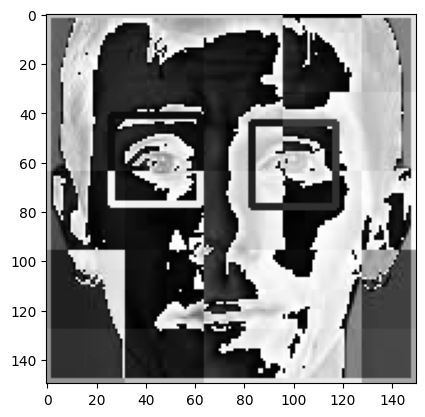

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region


Function to get a image and crop it if it has 2 eyes. We are converting it to grayscale to reduce a RGB dimension(Which makes things way easier)


In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found or unable to read: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            roi_color = img[y:y+h, x:x+w]
            return roi_color
    return None

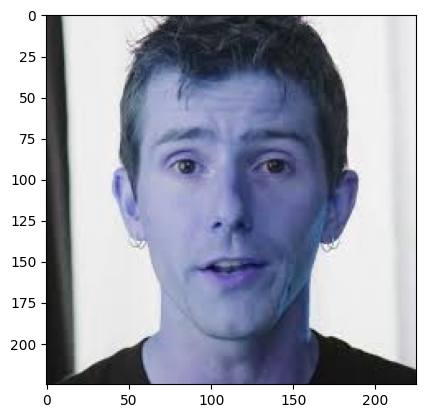

In [16]:
original_image = cv2.imread('./test_images/linus1.jpg')
plt.imshow(original_image)

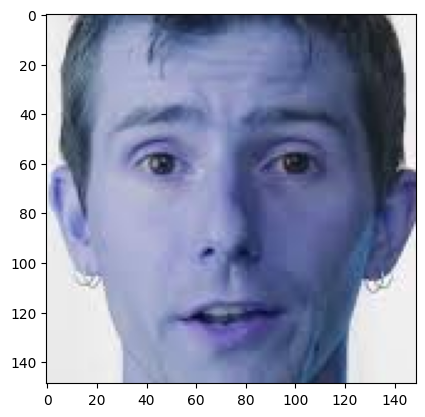

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/linus1.jpg')
plt.imshow(cropped_image)

**In the below image face is not very clear and it doesn't have two eyes clearly visible**


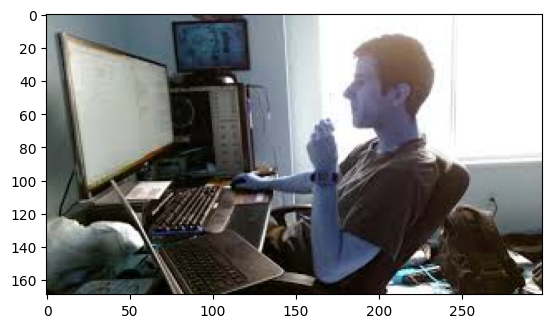

In [18]:
org_image_obstructed = cv2.imread('./test_images/linus2.jpeg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/linus2.jpeg')
cropped_image_no_2_eyes

This image doesn't have visible eyes so we won't use these images for training as of now


In [20]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [21]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [22]:
img_dirs

['./dataset/elon_musk',
 './dataset/harshita_gaur',
 './dataset/amber_heard',
 './dataset/linus_sebastian',
 './dataset/cropped']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after executing this code**


In [23]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:

cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        print(f"Processing file: {entry.path}")
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

print("Cropped image directories:", cropped_image_dirs)
print("Celebrity file names dict:", celebrity_file_names_dict)

Processing file: ./dataset/elon_musk/image_193.jpg
Processing file: ./dataset/elon_musk/image_178.jpg
Generating cropped images in folder:  ./dataset/cropped/elon_musk
Processing file: ./dataset/elon_musk/image_144.jpg
Processing file: ./dataset/elon_musk/image_352.jpg
Processing file: ./dataset/elon_musk/image_346.jpg
Processing file: ./dataset/elon_musk/image_72.jpeg
Processing file: ./dataset/elon_musk/image_25.jpeg
Processing file: ./dataset/elon_musk/image_233.jpg
Processing file: ./dataset/elon_musk/image_227.jpg
Processing file: ./dataset/elon_musk/image_390.jpg
Processing file: ./dataset/elon_musk/image_151.jpg
Processing file: ./dataset/elon_musk/image_179.jpg
Processing file: ./dataset/elon_musk/image_186.jpg
Processing file: ./dataset/elon_musk/image_192.jpg
Processing file: ./dataset/elon_musk/image_48.jpeg
Processing file: ./dataset/elon_musk/image_190.jpg
Processing file: ./dataset/elon_musk/image_153.jpg
Processing file: ./dataset/elon_musk/image_392.jpg
Processing file: